Cherkaoui Hamza Corbière Charles

# AXA Data Challenge Report

### Content table

1. **Get in touch with the data**
  1. Cleaning data and basic preprocessing
  2. Generate statistics
  3. Some visualizations  
2. **Prediction**
  4. First dummy submission and LinExp loss consideration
  5. Regressor on raw data
  6. Interpolation and repeating the past...
  7. A clever prediction merging
  8. Tuning the final pipline
3. **Anecdote**
  9. Bug on the server
  10. Local error: an Hold-Out and a V-fold script try
  11. Tuning parameters: an ```grid_search``` function try
4. **Conclusion**

## 1. **Get in touch with the data**

### 1.1 Cleaning data and basic preprocessing

First thing is to reduce the initial dataset file (more than 3 Gb). We have first code a functionto read the raw data and select only the chosen date and columns:
```python
def get_raw_data(data_path, date_regex, max_lines=None):
```   
Then the idea is to ```groupby``` by 30 minutes period and sum the number of calls. We have a specific function for this which take the output of ```get_raw_data``` and create a proper Pandas DataFrame with as mush columns than assignement:
```python
def preprocessing(X_df):
```  
After this first pass we have three differents files:
```
-rw-rw-r-- 1 hcherkaoui hcherkaoui 2,3M janv.  6 23:49 2011.csv
-rw-rw-r-- 1 hcherkaoui hcherkaoui 2,3M janv.  6 23:49 2012.csv
-rw-rw-r-- 1 hcherkaoui hcherkaoui 1,8M janv.  6 23:49 2013.csv
```
As you can see there are much lighter, but they hold all the necesseray information. For each file the corresponding DataFrame is:  

| index Dates  | CMS | Crises| Domicile  | ...  |  Tech. Total |
| ------------ |:---:|:-----:|:----------:-----:|:------------:|
| date 1       |  x  |   x   |     x     | ...  |       x      |


### 1.2 Generate statistics

In order to get a first impression on the evolution we have compute some statistic for the assignement:
- max call per assignement
- min per assignement
- mean per assignement
- 80% percentile per assignement
- 90% percentile per assignement
- variance per assignement

The statistics were produce by three times windows: years, months, days. And we produce separate statistics whether it's the day or the night. Finally, we end up by producing 18 files. Each refer to a DataFrame indexe by the time period and with 28 * 6 = 168 columns: 6 statistics per assignements.

### 1.3 Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2013_raw_data(assignements, type_periods, n_periods=5):
    df = pd.DataFrame.from_csv("datasets/2013.csv")
    if type_periods == "month":
        df = df.loc[df.index.month == n_periods]
    elif type_periods == "week":
        df = df.loc[df.index.week == n_periods]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plt.suptitle(u"Nb of calls per index of time", fontsize=10)
    for i, assignement in enumerate(assignements):
        axs.flat[i].plot(df[assignement])
        axs.flat[i].set_title(assignement.decode("utf-8"))

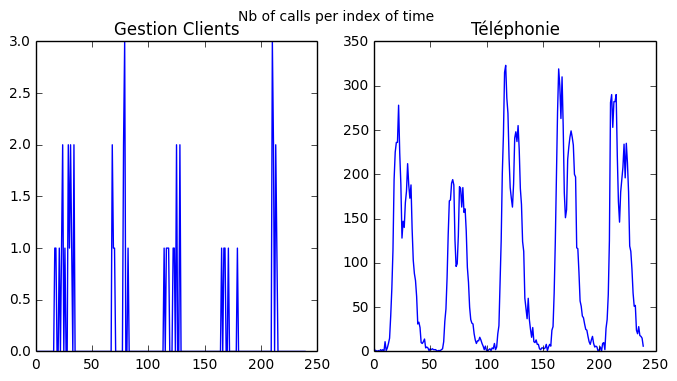

In [2]:
plot_2013_raw_data(['Gestion Clients', 'T\xc3\xa9l\xc3\xa9phonie'], "week", 5)

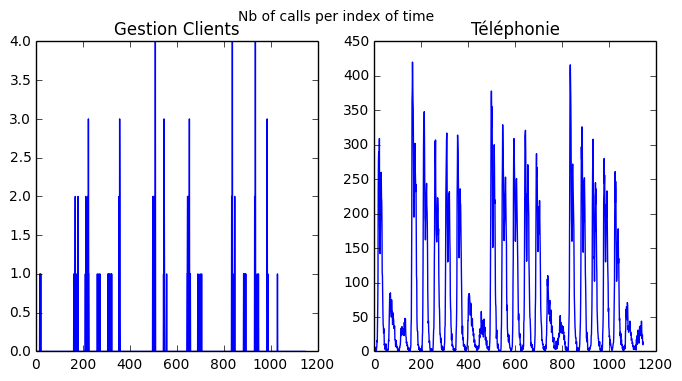

In [3]:
plot_2013_raw_data(['Gestion Clients', 'T\xc3\xa9l\xc3\xa9phonie'], "month", 3)

For 'Téléphonie', we can see that the calls follows a logical pattern. During the night there is less calls, as for the week end. And for monday morning we have a top activity. We can also observe that there is a slight tendencie to decrease throught the week.  
For 'Gestions clients', we have a more difficult parttern, we do not find the week pattern as in 'Téléphonie'.  
Those two examples were chosen to underline the fact that each assignements have a specific behaviour and order of magnitude. Even if most of assignements look like 'Gestion Clients', we have differents pattern. 

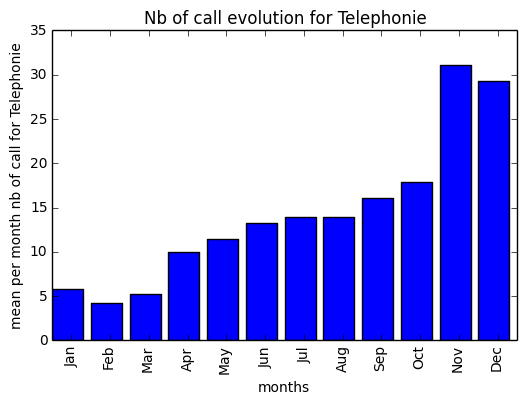

In [4]:
df = pd.DataFrame.from_csv("datasets/month_2011_stats_day.csv")
df = df.filter(regex=".* mean").drop("day mean", axis=1)
tel = df['T\xc3\xa9l\xc3\xa9phonie mean']
ind = np.array(range(tel.shape[0]))
plt.bar(ind, tel)
legend = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
width = 0.5
plt.xticks(ind + width, legend, rotation='vertical')
plt.ylabel("mean per month nb of call for Telephonie")
plt.xlabel("months")
plt.title("Nb of call evolution for Telephonie")
plt.show()

As we can see, even during a year some assignement average heavily increasing. At the end of the year in average we have a 500% increasing for 'Téléphonie'.  
Those obsevation were also done for all the assignements, all the year. And we notice that heavy increasing are commons.

Based on the two plots here, and the exploration of the data we made we can make several conclusion:  
* First, it's that we are far from a smooth evolution, meaning all the technique based on the functional analysis, derivation, etc should be useless here.
* The second is that, we have a huge evolution of the mean for each assignement, so year or even month tendency, are vital to catch during our prediction.  
* The third observation is that for each assignement, even if the mean change, we have a stable-periodic behaviour with noise. It's mean that the predictor will be able to learn at least this behaviour from the previous month (for example).

From this previous analysis we made those assumption. The main objectif of the challenge will be that for each assignement to capture the type random law of the nb of calls and its mean (which will evolve throught the year)
We can think of this as each assignement follow a Gaussian distribution and the variance and the mean evolve throught the year.

## 2. **Prediction**

### 2.1 First dummy submission and LinExp loss consideration

As we wanted to test our pipline and see how the testing serveur respond.  
We choose to take only one mean, the mean on 2012 for all assignement and use for every assignements, just to test. Our score were to big to be save...
And then we choose to finally take **half of the maximum means on all assignements** for 2012 and use it as a number of calls prediction for all the assignement. And our score were about a hundred.  

What we can conclude about this is the LinExp is very sensible to under-prediction. For example, for 'Téléphonie' is about hundred of calls, suppose you miss 100 calls, then you will pay it $e^{(0.1*100)} = 22026$... I means that we will have to **over estimate** a lot.

### 2.2 Regressor on raw data

Then our second idea was to try directly a predictor on the raw data. Meaning, giving 'something' that sum up the date, predict a specific assignment number of calls. We simply choose to do regression on the feature 'epoch':
```python
epoch = X_df.index.astype(int)
```
It was quite brutal approch and despite trying many differents regressors and hyperparameters we could improve our score.

### 2.3 Interpolation and repeating the past...

We then try a more manual approch. Because of the assignement evolution not beint smooth we couldn't use usual 'interpolling the past' to predict. Yet, because the behaviour repeat itself for each assignement one can think of just **repeating the past** with a ground base correction.  
Base on the idea we developpe two predictors:
```python
def pred_same_last_week(dates, X_df):

def pred_same_last_year(dates, X_df):

```  
Both we're based on:
```python
def get_last(date, X_df, period_type, nlast=1, nbtry=4):
    """
```  
Just to test, we have directly submit those two predictos and as expected they behave wrongly since because they do not take account of the ground base evolution,  ```pred_same_last_year``` being the best.  
So we try to take advantage of all the statistics that we have previously produice, the ```datasets/``` directory, but we had not better result. Finally, we choose to produce those two functions:
```python
def pred_reg_two_weeks(dates, X_df):

def pred_reg_two_years(dates, X_df):

```  
Submitting both of them separatly give use bad result aswell, the idea now was to mix all those prediction together in a clever way. At first try we average all the predictions but it gives used bad results since the predictors do not try to over-estimate the prediction, cf 2.1. So we try different 'merger': the 90% percentile, the 80% percentile, the maximum.
It ends that the best way of merging was taking the maximum of the four prediction.

### 2.4 A clever prediction merging

At this point we realize that we could simply **replace the merger by a learner**. Indeed, we can guess that our four "first pass" predictor produce differents errors per assignements. So we update our code such that we fit on all the date (except the one that we want to predict and a week before) with the output of the four predictors and the epoch feature.  
Thank to that approche we pass near the 0.6 error. At this point we also refactor the code to have a solid and clean base of code. We have different Python files and the prediction are made by a ```Regressor``` class. Our regressor call the ```GradientBoostingRegressor``` from Scikit-Learn with ```n_estimators=1000``` and ```learning_rate=0.2```.

```python
class Regressor(BaseEstimator):
    def __init__(self):

    def _fit_simple_predictors_(self, dates):

    def preprocess_data(self, df, full=False):

    def fit(self, dates):

    def predict(self, dates):

```

### 2.5 Tuning the final pipline

We have try several hyperparameters for our regressor, and to force the over-estimation we also multiplie our prediction by a coefficient (the first pass and the merged prediction). We end up by tuning **two coefficients and the ```GradientBoostingRegressor``` hyperparameters**. This allow us to make our best prediction. Yet we suppose that at some point we have ovefitted on the test datasets, which is recommendable.

## 3. **Anecdote**

### 3.1 Bug on the server

We have lost almost **13h** in finding what appear to us as a bug:
We produce such submission file.
```
DATE    ASS_ASSIGNMENT  prediction
2012-12-28 00:00:00 CMS     0.0
```
Meaning that we do not put the millisecond since it's the default Pandas behaviour.   
We are not sure why it's important to refuse a submission that do not display the millisecond. We cast this behaviour as a bug. Anyway the fact that the server only print a maximum error when the submission failed lure us for 13h... At some point we understand that it was not our predictor that create a huge error base on the LinExp loss function but it was 'only' a "Wrong file format error"... The server should have been more wordy about that. So since that we always manually corrected our submission file.

### 3.2 Local error: an Hold-Out and a V-fold script try

We have try to create a local estimation error. First we have try to compute a Hold-Out error estimation. We try to predict a week before what was ask on the server. The code run smoothly, yet we it was about to estimate the error a $0.36$ server error was estimate at $10^36$... we have no clue why since expression of the LinExp loss function is not that difficult. We have also try to make a V-fold function. But again the error estimation was huge..

### 3.3 Tuning parameters: an ```grid_search``` function try

In parallel of our effort on the error estimation we code a ```grid_search``` function hoping that when the error estimation will be solve we will be able to tune up our hyperparameters. But since the estimation error is still there, the ```grid_search``` function never work.

## 4. **Conclusion**

The main difficulty for this challenge was to made a robust code base to handle differents points:
* a cleaning and a preprocess step of the data 
* differents layers of predictors, and the ability to easily update/change it
* a script to create a proper submission file (almost working at the end)
* (optional) a script to estimate the error locally (not working...)
* (option) a script to make ```grid_search```(not working...)  

The main problem for us was that we were **not able to estimate the error locall** (and so to do ```grid_search```). It would have been perfect if we were able to validate a new technique locally and massively search the best hyperparameters. But instead we slowly try different technique.  
The second problem was that it seems to have many **random noise on the number of calls**. Which mean that even with many efforts this can't be 'catch' by our learner.  
The last 'problem' was the loss function, the **slightest error make the score increase dreadfully**. But, also, it was one of the interess of the challenge.

